In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import scipy.special as sp
import sklearn.datasets as datasets
import sklearn.linear_model as lm
import sklearn.ensemble as en
import sklearn.tree as tree
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
import econml
import importlib
import pyreadr

#### data generation packages
import strawman_edge
import strawman_center
import all_linear

#### main packages
import characterize
import estimate_atte as est
import learn_w as learn
import black

importlib.reload(est)
importlib.reload(learn)

import warnings

warnings.filterwarnings("ignore")

%load_ext jupyter_black
sns.set(font_scale=1.25, style="whitegrid")
np.random.seed(0)

In [2]:
outcome_cols = ["opioiduse12", "opioiduse24"]
treatment_col = "medicine_assigned"
discrete_cov = ["xrace", "mar", "sex"]

baseline_harmonized = pd.read_csv(
    "/Users/harshparikh/Library/CloudStorage/OneDrive-JohnsHopkins/MOUD_data/updated_data/ctn0094/drv/clean_patients_with_relapse_wide.csv",
    index_col=0,
)

# baseline_harmonized = baseline_harmonized.rename(
#     columns={col: col.split(".")[1] for col in baseline_harmonized.columns}
# ).set_index("who")

stacked_list = []
for i in range(1, 6):
    stacked_list.append(
        pd.read_csv(
            "/Users/harshparikh/Library/CloudStorage/OneDrive-JohnsHopkins/MOUD_data/stacked_list_%d.csv"
            % (i),
            index_col=0,
        )
    )
df = stacked_list[0]

df_tedsa = df.loc[df["trialdata"] == 0]

## TEDS-A vs CTN 27

In [3]:
ct94 = baseline_harmonized.loc[(baseline_harmonized["project"] == 27)]
outcome94 = ct94[outcome_cols]

common_cols = set.intersection(set(df_tedsa.columns), set(ct94.columns))

ct94_cc = ct94[common_cols].drop(columns=["edu", "mar"])
ct94_cc["sex"] = (ct94["sex"] == "male").astype(int)  # male = 1 and female = 0
# ct94_cc["mar"].loc[(1 - ct94_cc["mar"].isna()) == 1] = (ct94_cc["mar"] == 1.0).astype(
#     int
# )
# ct94_cc["edu"].loc[(1 - ct94_cc["edu"].isna()) == 1] = (ct94_cc["edu"] >= 2.0).astype(
#     int
# )

imputer = KNNImputer(n_neighbors=4, weights="distance", add_indicator=False)
ct94_cc_imputed = imputer.fit_transform(ct94_cc)

ct94_cc = pd.DataFrame(ct94_cc_imputed, index=ct94_cc.index, columns=ct94_cc.columns)

ct94_cc["med_met"] = (ct94[treatment_col] == "met").astype(
    int
)  # methadone = 1 and bupenorphine = 0
ct94_cc = ct94_cc.dropna()

ct94_cc["S"] = 1
ct94_cc = ct94_cc.round(0).astype(int)

ct94_cc = ct94_cc.join(outcome94, how="inner")
print(ct94_cc.shape)
ct94_cc.groupby(by="med_met").mean()[outcome_cols]

(1271, 11)


,opioiduse12,opioiduse24
med_met,,
0,0.629380,0.750674
1,0.553875,0.650284


In [4]:
df_tedsa_cc = df_tedsa[common_cols].drop(columns=["edu", "mar"])
df_tedsa_cc["S"] = 0
# invert age categories
df_tedsa_cc["age"].replace(
    {
        1: 13,
        2: 16,
        3: 18,
        4: 22,
        5: 27,
        6: 32,
        7: 37,
        8: 42,
        9: 47,
        10: 52,
        11: 60,
        12: 68,
    },
    inplace=True,
)

# df_tedsa_cc["mar"].loc[(1 - df_tedsa_cc["mar"].isna()) == 1] = (
#     df_tedsa_cc["mar"] == 1.0
# ).astype(int)
# df_tedsa_cc["edu"].loc[(1 - df_tedsa_cc["edu"].isna()) == 1] = (
#     df_tedsa_cc["edu"] >= 2.0
# ).astype(int)

In [5]:
df_primary = pd.concat([df_tedsa_cc.sample(frac=1, replace=False), ct94_cc])

df_ = df_primary.drop(columns=[outcome_cols[0]]).fillna(0)

In [6]:
outcome = outcome_cols[1]
treatment = "med_met"
sample = "S"
data = df_
S = df_[sample]  # indicator for the sample
Y = df_[outcome]  # outcome variable
T = df_[treatment]  # indicator for the treatment

data_dummy = pd.get_dummies(data, columns=["xrace"])
data_dummy.rename(
    columns={
        "sex": "Male",
        "age": "Age",
        "ivdrug": "IV Drug Use",
        "bamphetamine30_base": "Hx Amphetamine",
        "bbenzo30_base": "Hx Benzo",
        "bcannabis30_base": "Hx Cannabis",
        "xrace_1": "White",
        "xrace_2": "Black",
        "xrace_3": "Hispanic",
        "xrace_4": "Other Race",
        # "mar": "Married",
        # "edu": "Education(12y)",
    },
    inplace=True,
)

X = data_dummy.drop(columns=[outcome, treatment, sample])  # pre-treatment covariates

In [7]:
print(data_dummy.groupby(by=[sample]).quantile(0.75).T.round(2).to_latex())

\begin{tabular}{lrr}
\toprule
S &     0 &     1 \\
\midrule
Hx Amphetamine &   0.0 &   0.0 \\
IV Drug Use    &   1.0 &   1.0 \\
Hx Cannabis    &   0.0 &   1.0 \\
Male           &   1.0 &   1.0 \\
Age            &  47.0 &  46.0 \\
Hx Benzo       &   0.0 &   0.0 \\
med\_met        &   0.0 &   1.0 \\
opioiduse24    &   0.0 &   1.0 \\
White          &   1.0 &   1.0 \\
Black          &   0.0 &   0.0 \\
Hispanic       &   0.0 &   0.0 \\
Other Race     &   0.0 &   0.0 \\
\bottomrule
\end{tabular}



#### CTN Analysis

In [8]:
importlib.reload(learn)
df_v, pi, pi_m, e_m, data2 = learn.estimate_dml(
    data_dummy, outcome, treatment, sample, crossfit=5
)

Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


In [9]:
pd.concat(
    [
        df_v[["a", "te"]].mean() * 100,
        np.sqrt(df_v[["a_sq", "te_sq"]].mean() / df_v.shape[0]) * 100,
    ],
)

a       -9.982341
te      -9.329085
a_sq     4.740491
te_sq    6.802714
dtype: float64

In [10]:
np.random.seed(42)
pi_m = en.AdaBoostRegressor().fit(X.drop(columns=["Age"]), S)
exp_te_m = en.AdaBoostRegressor().fit(data2[X.drop(columns=["Age"]).columns], df_v["a"])

In [11]:
pd.concat(
    [
        pd.DataFrame(
            pi_m.feature_importances_,
            index=X.drop(columns=["Age"]).columns,
            columns=["Sample Selector"],
        ),
        pd.DataFrame(
            exp_te_m.feature_importances_,
            index=X.drop(columns=["Age"]).columns,
            columns=["Effect Modifier"],
        ),
    ],
    axis=1,
).round(2)

,Sample Selector,Effect Modifier
Hx Amphetamine,0.06,0.25
IV Drug Use,0.04,0.01
Hx Cannabis,0.85,0.20
Male,0.00,0.12
Hx Benzo,0.06,0.27
White,0.00,0.02
Black,0.00,0.00
Hispanic,0.00,0.01
Other Race,0.00,0.12


In [12]:
X.loc[S == 1].corr()

,Hx Amphetamine,IV Drug Use,Hx Cannabis,Male,Age,Hx Benzo,White,Black,Hispanic,Other Race
Hx Amphetamine,1.000000,0.130987,0.020362,-0.061050,0.000027,0.039875,0.016116,-0.065956,0.044326,-0.020377
IV Drug Use,0.130987,1.000000,-0.044030,0.061576,0.137469,-0.011916,0.000635,-0.075011,0.069444,-0.018398
Hx Cannabis,0.020362,-0.044030,1.000000,0.079745,-0.244685,0.072835,0.078055,-0.082146,-0.056653,0.027664
Male,-0.061050,0.061576,0.079745,1.000000,0.001715,-0.040418,0.003944,0.019002,0.020331,-0.055212
Age,0.000027,0.137469,-0.244685,0.001715,1.000000,-0.092735,-0.258507,0.312420,0.115704,-0.034361
Hx Benzo,0.039875,-0.011916,0.072835,-0.040418,-0.092735,1.000000,0.096661,-0.068683,-0.075729,0.007143
White,0.016116,0.000635,0.078055,0.003944,-0.258507,0.096661,1.000000,-0.442240,-0.635048,-0.415049
Black,-0.065956,-0.075011,-0.082146,0.019002,0.312420,-0.068683,-0.442240,1.000000,-0.134700,-0.088036
Hispanic,0.044326,0.069444,-0.056653,0.020331,0.115704,-0.075729,-0.635048,-0.134700,1.000000,-0.126418
Other Race,-0.020377,-0.018398,0.027664,-0.055212,-0.034361,0.007143,-0.415049,-0.088036,-0.126418,1.000000


#### Transporting Effects

In [13]:
importlib.reload(learn)
# D, w_tree, testing_data = learn.tree_opt(data, outcome, treatment, sample, leaf_proba=1)
np.random.seed(42)
D_rash, D_forest, w_forest, rashomon_set, f, testing_data = learn.forest_opt(
    data=data_dummy,
    outcome=outcome,
    treatment=treatment,
    sample=sample,
    leaf_proba=0.5,
    num_trees=5000,
    vote_threshold=5 / 10,
    # top_k_trees=True,
    # k=5,
)

baseline_loss = np.sqrt(np.sum(D_forest["vsq"]) / ((D_forest.shape[0] ** 2)))
print("Baseline Objective:%.4f" % (baseline_loss))

Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
ATE Est: -0.0494
leaf              0.333333
Hx Amphetamine    0.018274
IV Drug Use       0.100171
Hx Cannabis       0.275885
Male              0.021388
Age               0.004985
Hx Benzo          0.007219
White             0.058674
Black             0.012871
Hispanic          0.060698
Other Race        0.106502
dtype: float64
Baseline Objective:0.0650


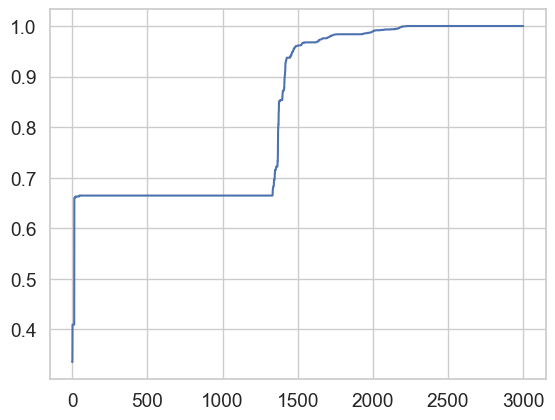

In [29]:
local_obj = pd.DataFrame(
    np.array([w_forest[i]["local objective"] for i in range(len(w_forest))]),
    columns=["Objective"],
).sort_values(by="Objective")

top_k = 3000
plt.plot((local_obj.iloc[:top_k] / baseline_loss)["Objective"].values)

In [43]:
w_rash = [
    "w_tree_%d" % (i)
    for i in range(len(w_forest))
    if i in list(local_obj.iloc[:top_k].index)
]
avg_votes = (D_forest[w_rash].mean(axis=1) >= 0.5).astype(int)

np.random.seed(42)
num_trees = 1
explainer = tree.DecisionTreeClassifier(max_leaf_nodes=16).fit(
    X.drop(columns=["Age"]).loc[avg_votes.index], avg_votes
)

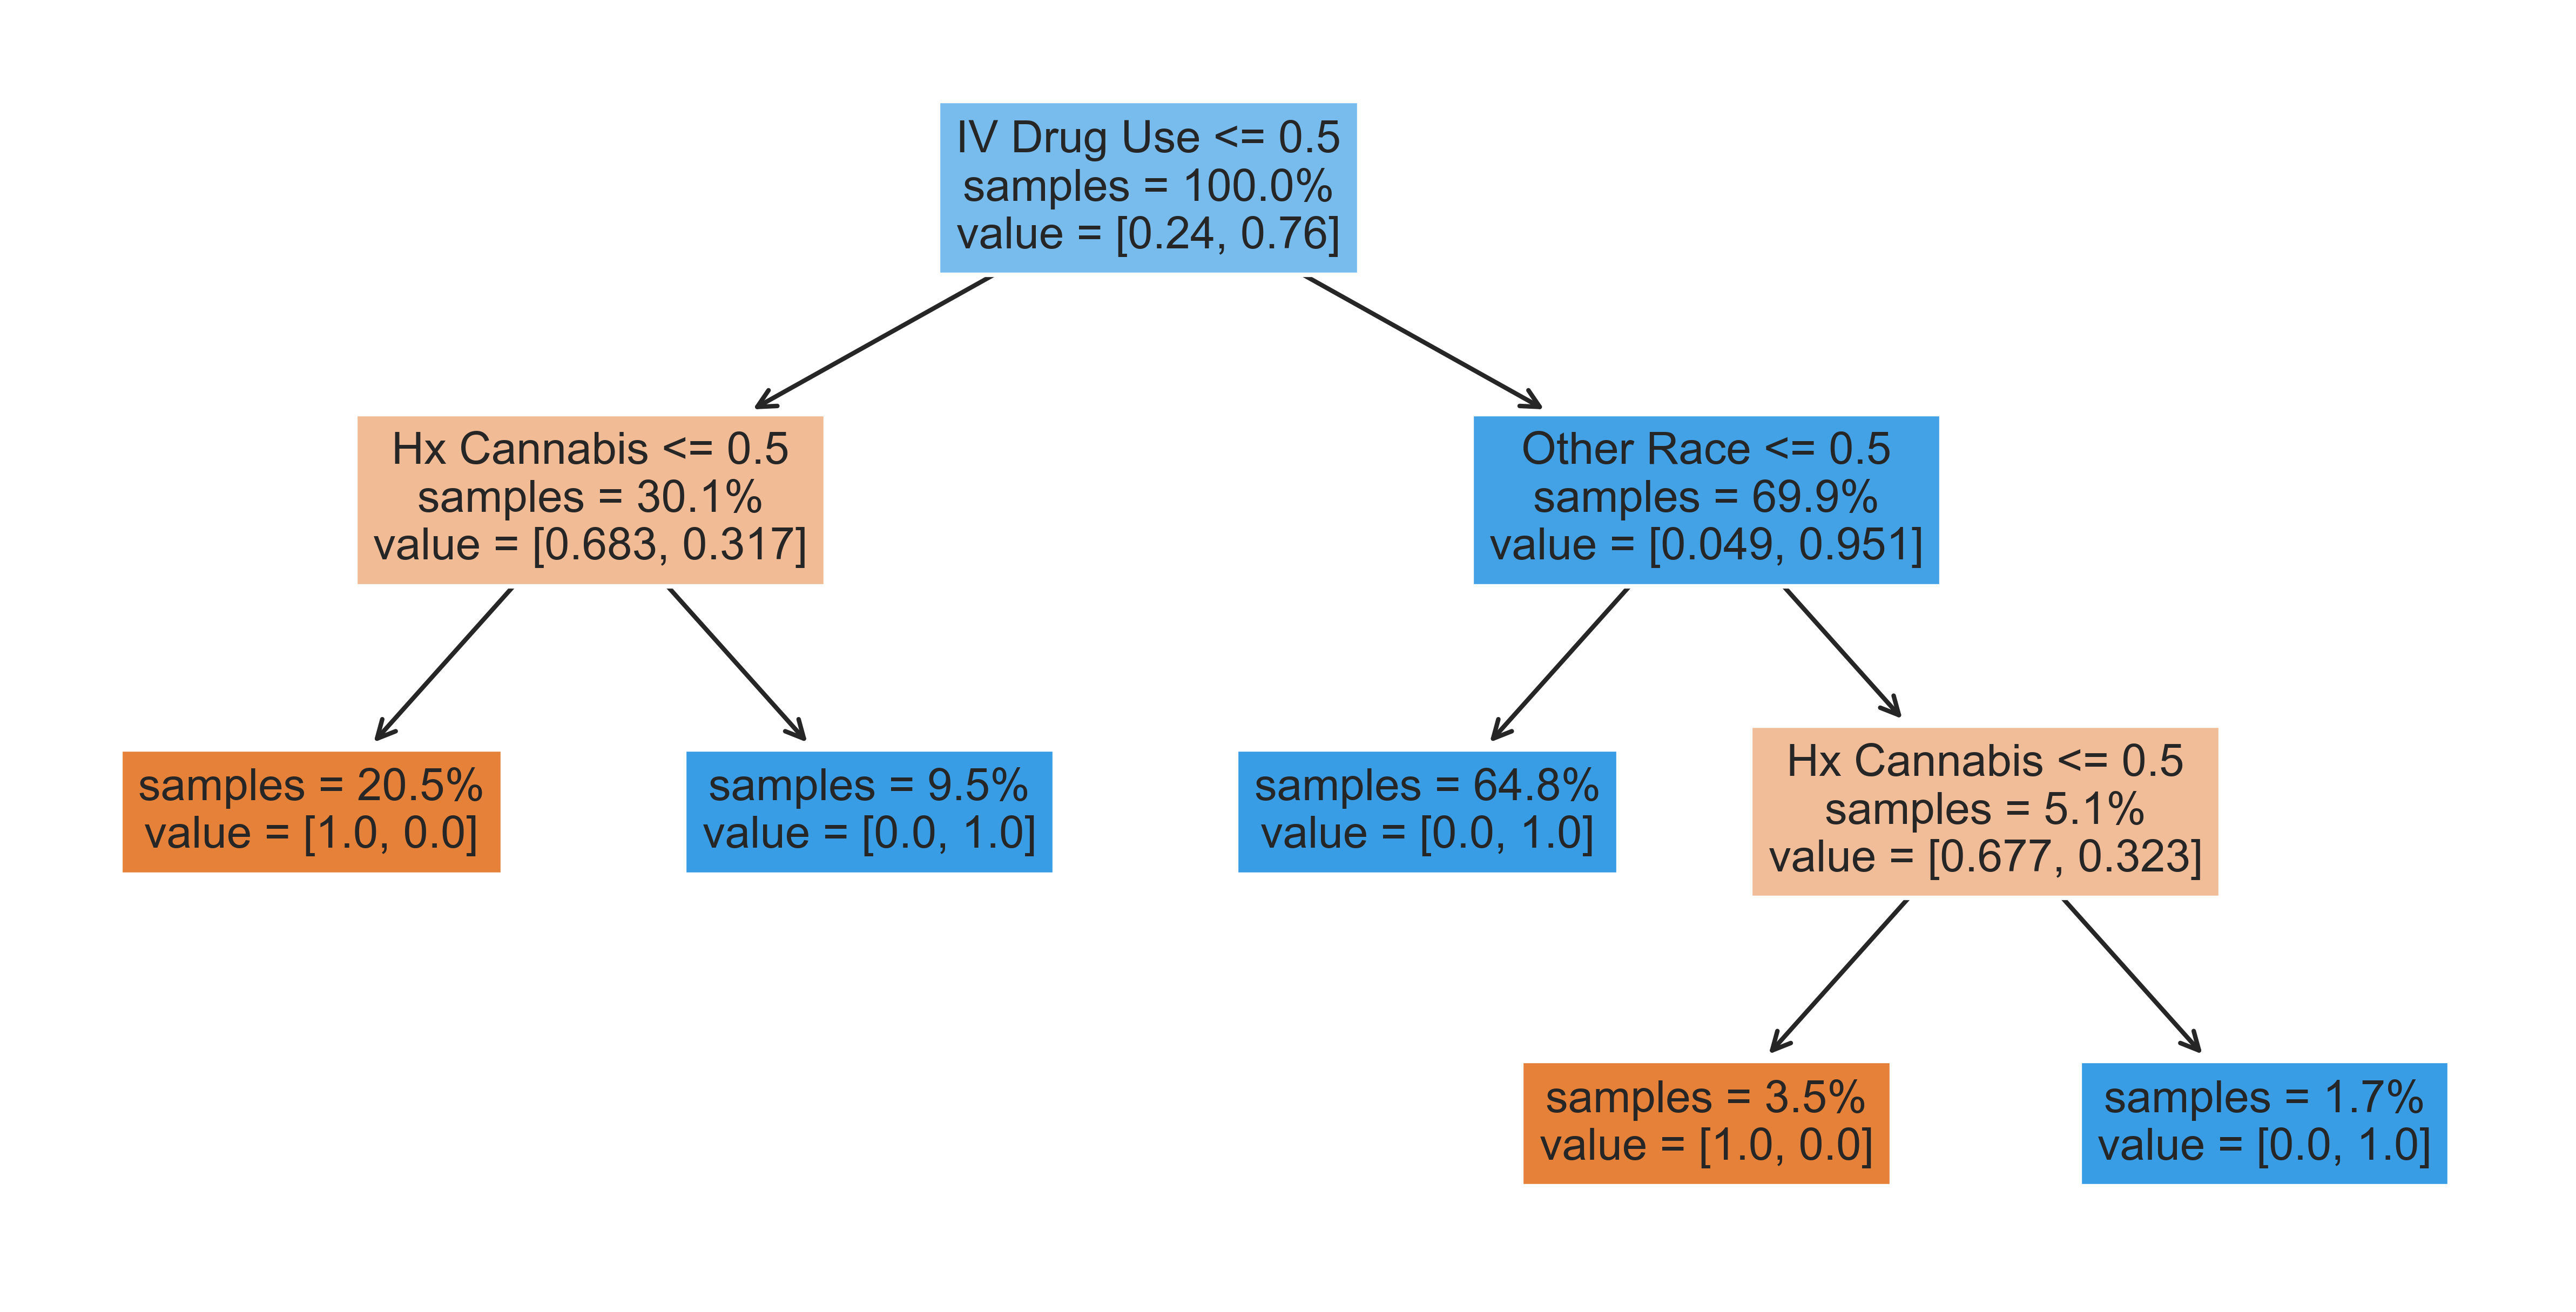

In [50]:
fig, ax = plt.subplots(nrows=num_trees, figsize=(10, 5), dpi=600)
for i in range(num_trees):
    if num_trees == 1:
        tree.plot_tree(
            explainer,  # .estimators_[i, 0],
            feature_names=X.drop(columns=["Age"]).columns,
            ax=ax,
            filled=True,
            fontsize=10,
            proportion=True,
            impurity=False,
        )
    else:
        tree.plot_tree(
            explainer.estimators_[i, 0],
            feature_names=X.drop(columns=["Age"]).columns,
            ax=ax[i],
            filled=True,
            fontsize=10,
            proportion=True,
        )
plt.savefig("tedsa_ctn27.pdf", dpi=600)

In [45]:
w = explainer.predict(data_dummy[X.drop(columns=["Age"]).columns])
data_dummy["w"] = w

pd.concat(
    [
        data_dummy.groupby(by="S").mean().T.round(2),
        data_dummy.loc[data_dummy["w"] == 1].groupby(by="S").mean().T.round(2),
    ],
    axis=1,
) * 100

S,0,1,0,1
Hx Amphetamine,7.0,13.0,8.0,14.0
IV Drug Use,54.0,70.0,91.0,87.0
Hx Cannabis,11.0,29.0,20.0,38.0
Male,58.0,68.0,61.0,70.0
Age,3807.0,3688.0,3665.0,3704.0
Hx Benzo,6.0,17.0,6.0,17.0
med_met,0.0,42.0,0.0,41.0
opioiduse24,0.0,71.0,0.0,73.0
White,65.0,68.0,74.0,71.0
Black,15.0,9.0,9.0,7.0


In [46]:
print(
    r"Pre Pruning, SATE: %.2f ± %.2f"
    % (
        100
        * (
            df_.loc[(df_[sample] == 1) * (df_[treatment] == 1), outcome].mean()
            - df_.loc[(df_[sample] == 1) * (df_[treatment] == 0), outcome].mean()
        ),
        100
        * 1.96
        * (
            df_.loc[(df_[sample] == 1) * (df_[treatment] == 1), outcome].sem()
            + df_.loc[(df_[sample] == 1) * (df_[treatment] == 0), outcome].sem()
        ),
    )
)

print(
    r"Pre Pruning, ATTE: %.2f ± %.2f"
    % (
        100 * D_rash["v"].mean(),
        100 * 1.96 * np.sqrt(D_rash["vsq"].sum() / (D_rash["w_opt"].count()) ** 2),
    )
)

D_rash["w_opt"] = explainer.predict(X.drop(columns=["Age"]).loc[avg_votes.index])
print(
    r"Post Pruning, ATTE: %.2f ± %.2f"
    % (
        100 * D_rash["v"].loc[D_rash["w_opt"] == 1].mean(),
        100
        * 1.96
        * np.sqrt(
            D_rash["vsq"].loc[D_rash["w_opt"] == 1].sum()
            / ((D_rash["w_opt"].sum()) ** 2)
        ),
    )
)

Pre Pruning, SATE: -10.04 ± 7.18
Pre Pruning, ATTE: -4.94 ± 12.74
Post Pruning, ATTE: -8.46 ± 11.94


(0.0609371163009151, 0.06501252724958022)


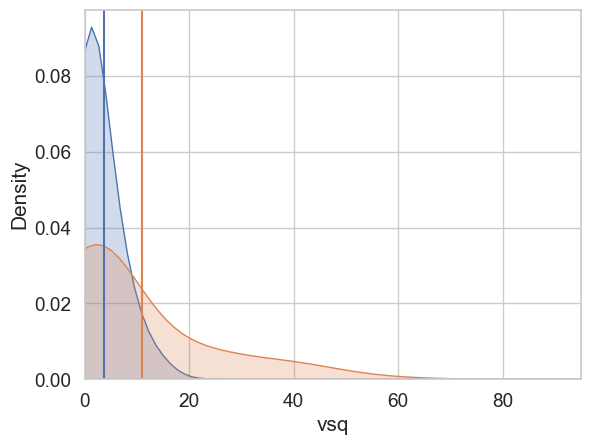

In [47]:
sns.kdeplot(D_rash.loc[D_rash["w_opt"] == 1]["vsq"], fill=True)
sns.kdeplot(D_rash.loc[D_rash["w_opt"] == 0]["vsq"], fill=True)
plt.axvline(D_rash.loc[D_rash["w_opt"] == 1]["vsq"].mean(), c="C0")
plt.axvline(D_rash.loc[D_rash["w_opt"] == 0]["vsq"].mean(), c="C1")
plt.xlim(0, 95)
print(
    (
        np.sqrt(
            D_rash.loc[data_dummy["w"] == 1]["vsq"].mean()
            / D_rash.loc[data_dummy["w"] == 1]["vsq"].count()
        ),
        np.sqrt(D_rash["vsq"].mean() / D_rash["vsq"].count()),
    )
)

(-0.08462897152620014, 0.062354655506615723)


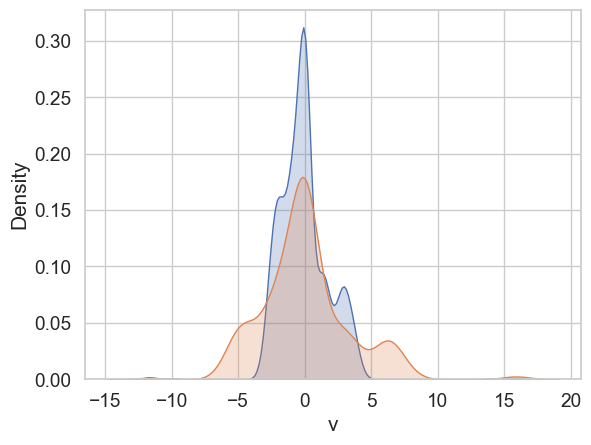

In [48]:
sns.kdeplot(D_rash.loc[D_rash["w_opt"] == 1]["v"], fill=True)
sns.kdeplot(D_rash.loc[D_rash["w_opt"] == 0]["v"], fill=True)
print(
    (
        D_rash.loc[D_rash["w_opt"] == 1]["v"].mean(),
        D_rash.loc[D_rash["w_opt"] == 0]["v"].mean(),
    )
)

In [49]:
D_forest.to_csv("tedsa_analysis_forest_opt.csv")
D_rash.to_csv("tedsa_analysis_forest_rashomon_opt.csv")